Filtered points and labels saved to data/filtered_points_with_labels.npz


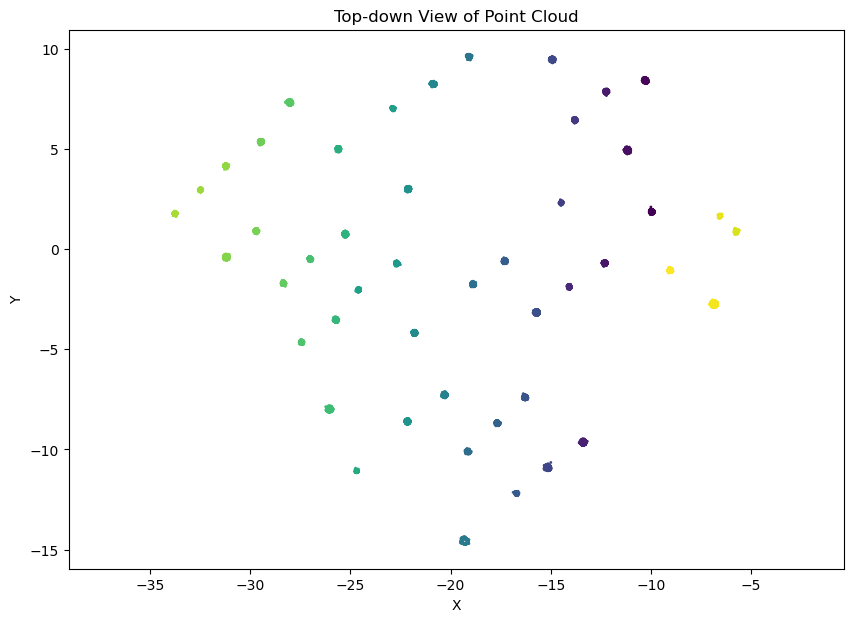

In [4]:
# Import necessary libraries
import laspy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Load the .las file and extract points
def load_las(file_path):
    with laspy.open(file_path) as las:
        las_data = las.read()
        points = np.vstack((las_data.x, las_data.y, las_data.z)).T
    return points

# Visualize the point cloud with labels (top-down 2D view)
def visualize_top_down(points, labels=None):
    plt.figure(figsize=(10, 7))
    if labels is None:
        plt.scatter(points[:, 0], points[:, 1], s=1, c='gray')
    else:
        plt.scatter(points[:, 0], points[:, 1], s=1, c=labels, cmap='viridis')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Top-down View of Point Cloud')
    plt.axis('equal')
    plt.show()

# Remove clusters that are outliers based on size distribution
def filter_outlier_clusters(points, labels):
    unique_labels = np.unique(labels)
    cluster_sizes = [np.sum(labels == label) for label in unique_labels if label != -1]

    if len(cluster_sizes) == 0:
        return points, labels

    # Calculate mean and standard deviation of cluster sizes
    mean_size = np.mean(cluster_sizes)
    std_size = np.std(cluster_sizes)

    # Define acceptable size range (e.g., within 3 standard deviations)
    min_size = max(0, mean_size - 3 * std_size)
    max_size = mean_size + 3 * std_size

    filtered_points = []
    filtered_labels = []

    for label in unique_labels:
        if label == -1:  # Ignore noise points
            continue
        cluster_points = points[labels == label]
        if min_size <= len(cluster_points) <= max_size:
            filtered_points.append(cluster_points)
            filtered_labels.append(np.full(len(cluster_points), label))

    if filtered_points:
        filtered_points = np.vstack(filtered_points)
        filtered_labels = np.concatenate(filtered_labels)
    else:
        filtered_points = np.empty((0, 3))
        filtered_labels = np.empty((0,))

    return filtered_points, filtered_labels

# Filter clusters by circularity in the XY plane
def filter_circular_clusters(points, labels, min_circularity=0.6):
    """
    Filtre les clusters en fonction de leur circularité (projetée sur XY).
    """
    unique_labels = np.unique(labels)
    filtered_points = []
    filtered_labels = []

    for label in unique_labels:
        if label == -1:  # Ignore noise points
            continue
        cluster_points = points[labels == label]
        if len(cluster_points) < 3:
            continue

        # Projet sur le plan XY
        xy_points = cluster_points[:, :2]
        cov_matrix = np.cov(xy_points, rowvar=False)
        eigenvalues, _ = np.linalg.eigh(cov_matrix)
        eigenvalues = np.sort(eigenvalues)

        # Calcul de la circularité (rapport des axes)
        circularity = eigenvalues[0] / eigenvalues[1] if eigenvalues[1] > 0 else 0

        if circularity >= min_circularity:
            filtered_points.append(cluster_points)
            filtered_labels.append(np.full(len(cluster_points), label))

    if filtered_points:
        filtered_points = np.vstack(filtered_points)
        filtered_labels = np.concatenate(filtered_labels)
    else:
        filtered_points = np.empty((0, 3))
        filtered_labels = np.empty((0,))

    return filtered_points, filtered_labels

# Step 1: Load the .las file
file_path = "data/forest_cut.las"  # Update with your .las file path
points = load_las(file_path)

# Step 2: Filter points by height (z-axis)
min_z, max_z = 0.0, 5.0  # Define height range
filtered_points = points[(points[:, 2] >= min_z) & (points[:, 2] <= max_z)]

# Step 3: Apply DBSCAN clustering
epsilon = 0.2  # Maximum distance between points to be considered in the same neighborhood
min_samples = 10  # Minimum number of points to form a cluster
clustering = DBSCAN(eps=epsilon, min_samples=min_samples).fit(filtered_points)
labels = clustering.labels_

# Step 4: Filter clusters to remove outliers
filtered_points, filtered_labels = filter_outlier_clusters(filtered_points, labels)

# Step 5: Filter clusters by circularity
filtered_points, filtered_labels = filter_circular_clusters(filtered_points, filtered_labels, min_circularity=0.6)

# Step 6: Save filtered points and labels
output_file = "data/filtered_points_with_labels.npz"
np.savez(output_file, points=filtered_points, labels=filtered_labels)
print(f"Filtered points and labels saved to {output_file}")

# Step 7: Visualize the filtered point cloud (top-down 2D view)
visualize_top_down(filtered_points, filtered_labels)
